In [ ]:
!pip install pdf2image

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,426 kB/s)
debconf: unable to initi

In [ ]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=f1ef960ae3cb991dedc126ca2fa4883b07250cadb1743fe7f957d2305caf96ec
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


In [ ]:
!pip install tesseract

     |████████████████████████████████| 45.6 MB 50 kB/s 
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562569 sha256=66139b72f0aa649166e73df36c3a6ba38c5187e10581f8b8e8b56937ad47d9f7
  Stored in directory: /root/.cache/pip/wheels/01/3f/af/2f732560b9c4e51dd131bcbc6b7466a3124d15ab3fd393f85a
Successfully built tesseract


In [ ]:
# -*- coding: utf-8 -*-
import os
import csv
import sys
import shutil
import subprocess
import configparser
import argparse
import json
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import cv2

from pdf2image import convert_from_path
import pytesseract
from pytesseract import Output

font = ImageFont.load_default()
pd.set_option("max_rows", 500)

In [ ]:
# Function to write bounding boxes from available annotations for FUNSD Dataset
def bbox_annotation(image_path,json_path):

  
  bbox = []
  image = Image.open(image_path)
  image = image.convert('RGB')
  draw = ImageDraw.Draw(image)
  with open(json_path, "r", encoding="utf8") as f:
    data = json.load(f)
  for item in data["form"]:
    words, label, bbox = item["words"], item["label"], item["box"]
    for w in words:
      bbox = w["box"]
      text = w["text"]
      draw.rectangle(bbox, outline= "green", width=2)
      draw.text((bbox[0] + 10, bbox[1] - 10), text.encode('utf-8') , fill ="green", font=font) 
  return image

In [ ]:
# Function call to write bounding boxes from annotation by passing JSON file and Image
image1 = bbox_annotation('/content/93213298.png', '/content/93213298.json')
image1

In [ ]:
# Function to write bounding boxes from values extracted from OCR and filtered few text values from OCR 
def bbox_pytessaract(image_path, json_path):
  bbox=[]
  #bbox
  image1 = bbox_annotation(image_path, json_path)
  draw = ImageDraw.Draw(image1)
  #ocr image

  image = Image.open(image_path)
  width, height = image.size
  w_scale = 1000/width
  h_scale = 1000/height
  ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
  #ocr = ocr_df[["text","left", "top", "width", "height"]]
  draw = ImageDraw.Draw(image1)
  font = ImageFont.load_default()
  ocr_df['n_width'] = ocr_df['left']+ocr_df['width']
  ocr_df['n_height'] = ocr_df['top']+ocr_df['height']
  ocr_df['bbox'] = ocr_df[["left", "top", "n_width", "n_height"]].values.tolist()
  #print(ocr_df['text'])
  ocr_na = ocr_df.dropna()
  #print('*****')
  #print(ocr_na['text'])
  float_cols = ocr_na.select_dtypes('float').columns
  ocr_na[float_cols] = ocr_na[float_cols].round(0).astype(int)
  #print(ocr_na.shape[0])
  """for index,row in ocr_na.iterrows():
    if(row['text'] == ' '):
      print('empty space',index)
      ocr_na = ocr_na.drop(index)
    if(row['top']== 0):
      print('image size bbox',index)
      ocr_na = ocr_na.drop(index)"""
  for index,row in ocr_na.iterrows():
    #print(row['bbox'])
    text = row['text']
    bounding_box = row['bbox']
    draw.rectangle(bounding_box, outline= "red", width=2)
    draw.text((bounding_box[0] + 10, bounding_box[1] - 10), text.encode('utf-8') , fill ="red", font=font)
  return ocr_na, image1

In [ ]:
ocr1, image_now1 = bbox_pytessaract('/content/91581919.png', '/content/91581919.json')
image_now1


empty space 9
empty space 46
empty space 97
empty space 194
empty space 227
empty space 241
empty space 242
empty space 243
empty space 244


In [ ]:
ocr1.head()

level  page_num  block_num  ...  n_width  n_height                  bbox
4       5         1          1  ...      202        75    [176, 55, 202, 75]
5       5         1          1  ...      242        68    [207, 45, 242, 68]
13      5         1          3  ...      169        87    [136, 65, 169, 87]
15      5         1          3  ...      372       126  [288, 113, 372, 126]
16      5         1          3  ...      399       126  [381, 113, 399, 126]
17      5         1          3  ...      512       125  [410, 113, 512, 125]
19      5         1          3  ...      148       164  [111, 152, 148, 164]
20      5         1          3  ...      240       168  [157, 151, 240, 168]
21      5         1          3  ...      278       163  [257, 153, 278, 163]
22      5         1          3  ...      329       165  [286, 153, 329, 165]
23      5         1          3  ...      388       162  [338, 153, 388, 162]
24      5         1          3  ...      446       163  [440, 161, 446, 163]
25      5         1          3  ...      586       164  [521, 153, 586, 164]
26      5         1          3  ...      638       179  [596, 152, 638, 179]
27      5         1          3  ...      705       176  [640, 152, 705, 176]
29      5         1          3  ...      156       210  [110, 198, 156, 210]
30      5         1          3  ...      185       210  [167, 199, 185, 210]
31      5         1          3  ...      255       207  [206, 198, 255, 207]
32      5         1          3  ...      388       212  [384, 197, 388, 212]
33      5         1          3  ...      576       213  [521, 199, 576, 213]

[20 rows x 15 columns]

In [ ]:
ocr2, image_now2 = bbox_pytessaract('/content/92094746.png', '/content/92094746.json')
image_now2

empty space 4
empty space 13
empty space 45
image size bbox 50
image size bbox 51
empty space 69
image size bbox 91
empty space 149
empty space 171
empty space 190
empty space 223


empty space 4
empty space 25
empty space 42
empty space 73
empty space 153
empty space 167
empty space 171


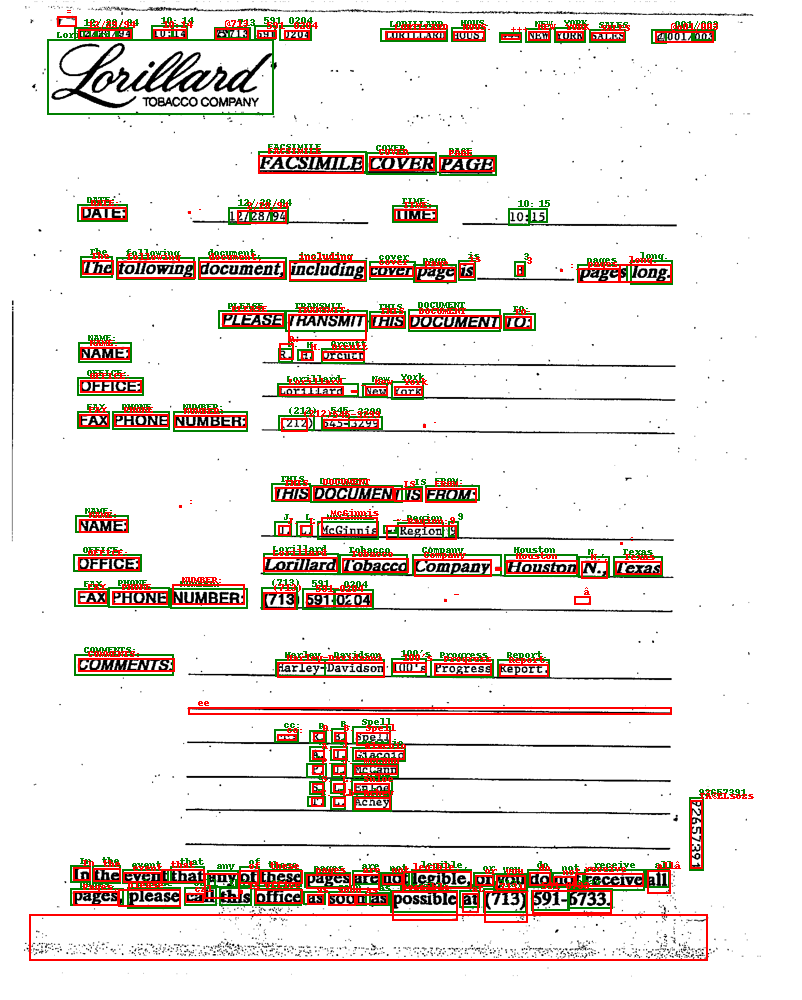

In [ ]:
ocr3, image_now3 = bbox_pytessaract('/content/92657391.png', '/content/92657391.json')
image_now3

In [ ]:
ocr4, image_now4 = bbox_pytessaract('/content/93213298.png', '/content/93213298.json')
image_now4

image size bbox 17
empty space 54
empty space 132
empty space 136


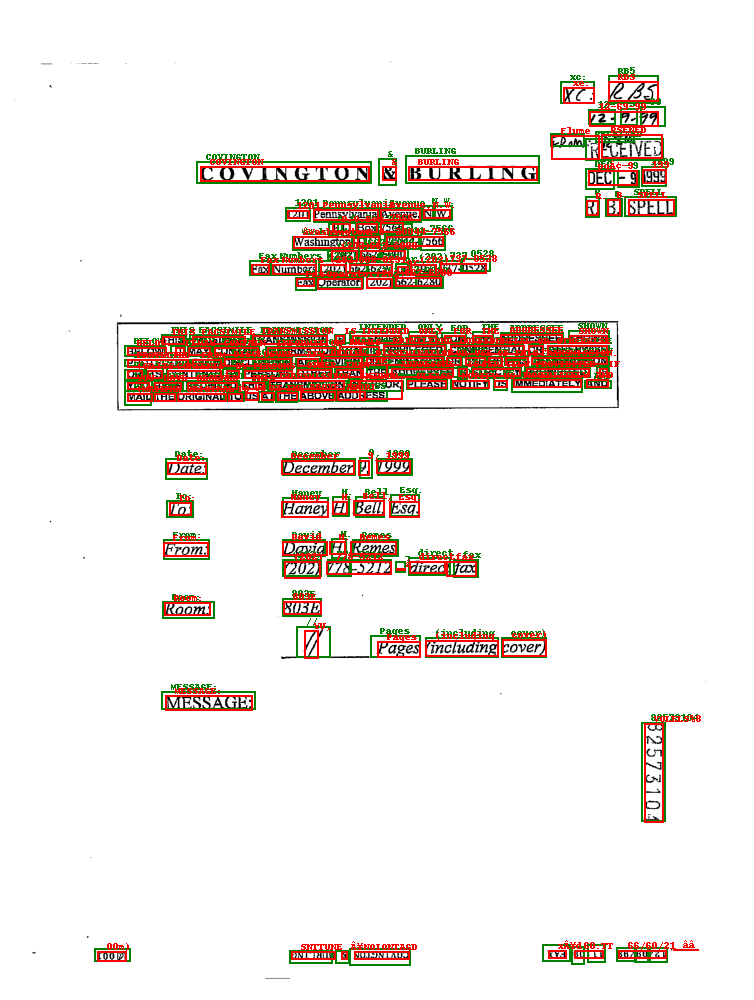

In [ ]:
ocr5, image_now5 = bbox_pytessaract('/content/82573104.png', '/content/82573104.json')
image_now5